In [37]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



In [38]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            self.world = np.chararray((self.world_height, self.world_width))
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True

        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True

        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info

    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1

        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1

        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

Here is one example random agent class:

In [39]:
class RandomAgent:
    def __init__(self, env, num_episodes):
        self.action_space = [1, 2, 3, 4]
        self.env = env
        self.num_episodes = num_episodes

    def act(self):
        """Returns a random choice of the available actions"""
        return np.random.choice(self.action_space)

    def learn(self):
        rewards = []

        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                action = self.act()
                next_state, reward, done, info = self.env.step(action)
                cumulative_reward += reward
                state = next_state
            rewards.append(cumulative_reward)

        return rewards

You need to complete the learn() method of the following class to implement your RL algorithm.

### Using Q-learning

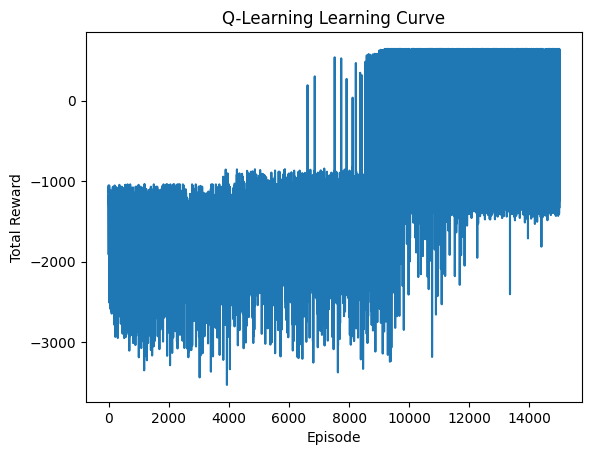

In [40]:
class RLAgent_QL:
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space
        self.q_table = dict() # Store all Q-values in a dictionary
        # Loop through all possible grid spaces, create sub-dictionary for each
        for agent_x in range(env.world_height):
            for agent_y in range(env.world_width):
                for box_x in range(env.world_height):
                    for box_y in range(env.world_width):
                        # Populate sub-dictionary with zero values for possible moves
                        self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}

        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def act(self, state):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space[np.random.randint(0, len(self.action_space))]
        else:
            q_values_of_state = self.q_table[state]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])

        return action

    def learn(self):
      rewards = []
      for _ in range(self.num_episodes):
        cumulative_reward = 0  # Initialize values of each game
        state = self.env.reset()
        done = False
        while not done:  # Run until the game is terminated
            action = self.act(state)  # Choose an action based on epsilon-greedy strategy
            next_state, reward, done, info = self.env.step(action)  # Take the action in the environment
            cumulative_reward += reward

            # Update Q-values using the Q-learning algorithm
            q_values = self.q_table[state]
            next_q_values = self.q_table[next_state]
            max_next_q_value = max(next_q_values.values())
            q_values[action] += self.alpha * (reward + self.gamma * max_next_q_value - q_values[action])

            state = next_state  # Move to the next state

        rewards.append(cumulative_reward)
      return rewards
env = CliffBoxGridWorld()
agent = RLAgent_QL(env, num_episodes=15000)
rewards = agent.learn()

# Plot the learning curve
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning Learning Curve')
plt.show()

### Using SARSA

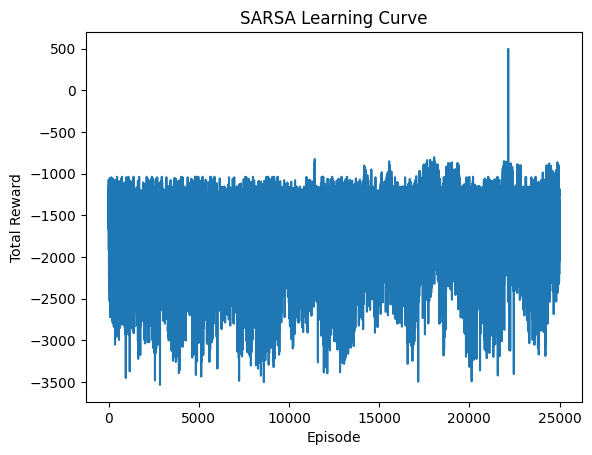

In [41]:
class RLAgent_SARSA:
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space
        self.q_table = dict() # Store all Q-values in a dictionary
        # Loop through all possible grid spaces, create sub-dictionary for each
        for agent_x in range(env.world_height):
            for agent_y in range(env.world_width):
                for box_x in range(env.world_height):
                    for box_y in range(env.world_width):
                        # Populate sub-dictionary with zero values for possible moves
                        self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}

        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def act(self, state):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space[np.random.randint(0, len(self.action_space))]
        else:
            q_values_of_state = self.q_table[state]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])

        return action

    def learn(self):
      rewards = []
      for _ in range(self.num_episodes):
        cumulative_reward = 0  # Initialize values of each game
        state = self.env.reset()
        done = False
        action = self.act(state)  # Choose the first action based on epsilon-greedy strategy

        while not done:  # Run until the game is terminated
            next_state, reward, done, info = self.env.step(action)  # Take the action in the environment
            next_action = self.act(next_state)  # Choose the next action based on epsilon-greedy strategy

            # Update Q-values using the SARSA algorithm
            q_values = self.q_table[state]
            next_q_value = self.q_table[next_state][next_action]
            q_values[action] += self.alpha * (reward + self.gamma * next_q_value - q_values[action])

            cumulative_reward += reward
            state = next_state
            action = next_action

        rewards.append(cumulative_reward)
      return rewards
env = CliffBoxGridWorld()
agent = RLAgent_SARSA(env, num_episodes=25000)
rewards = agent.learn()

# Plot the learning curve
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('SARSA Learning Curve')
plt.show()

### Using UCB exploration technique

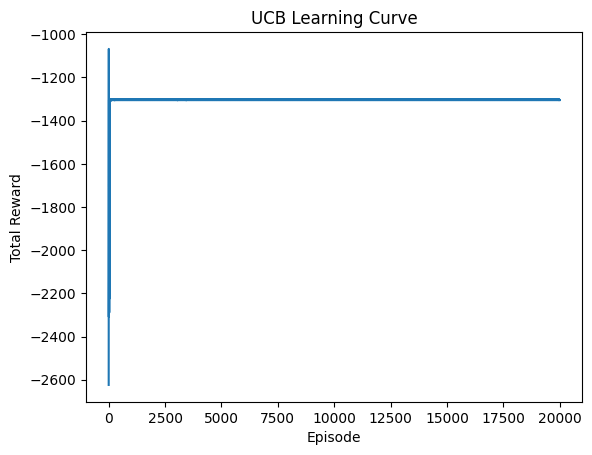

In [42]:
import math

class UCBRLAgent:
    def __init__(self, env, num_episodes, c=2.0):
        self.action_space = env.action_space
        self.q_table = dict()
        self.action_counts = dict()  # Keep track of the number of times each action is selected
        self.num_episodes = num_episodes
        self.env = env
        self.c = c

    def act(self, state, timestep):
        # Calculate the UCB values for each action
        ucb_values = []
        for action in self.action_space:
            if (state, action) in self.q_table:
                q_value = self.q_table[(state, action)]
                n = self.action_counts.get((state, action), 0)
                exploration_bonus = self.c * math.sqrt(math.log(timestep) / (n + 1e-6))
                ucb_value = q_value + exploration_bonus
                ucb_values.append((action, ucb_value))
            else:
                # If the action has not been explored yet, prioritize it
                ucb_values.append((action, float('inf')))

        # Choose the action with the highest UCB value
        best_action = max(ucb_values, key=lambda x: x[1])[0]
        return best_action

    def learn(self):
        rewards = []
        for episode in range(self.num_episodes):
            cumulative_reward = 0
            state = self.env.reset()
            done = False
            timestep = 1

            while not done:
                action = self.act(state, timestep)
                next_state, reward, done, _ = self.env.step(action)
                cumulative_reward += reward

                # Update Q-values
                if (state, action) in self.q_table:
                    self.q_table[(state, action)] += (reward - self.q_table[(state, action)]) / (self.action_counts[(state, action)] + 1)
                else:
                    self.q_table[(state, action)] = reward

                # Update action counts
                self.action_counts[(state, action)] = self.action_counts.get((state, action), 0) + 1

                state = next_state
                timestep += 1

            rewards.append(cumulative_reward)
        return rewards

env = CliffBoxGridWorld()
agent = UCBRLAgent(env, num_episodes=20000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('UCB Learning Curve')
plt.show()

Here is the game interface where you can manually move the agent.

In [46]:
env = CliffBoxGridWorld(render=True)
env.reset()
env.print_world()
done = False
rewards = []

while not done:
    action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
Please input the actions (up: 1, down: 2, left: 3, right: 4): 4
step: 1, state: (5, 1, 4, 1), actions: 4, reward: -14
Action: 4
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'_' b'A' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b

Example code to step random agent in the environment.

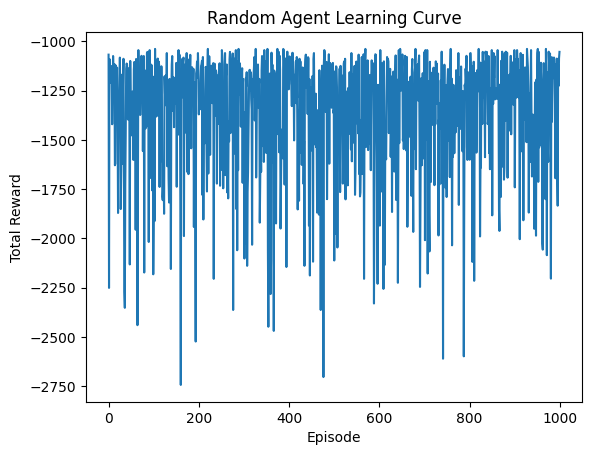

In [47]:
# Initialize the environment and agent
env = CliffBoxGridWorld()
agent = RandomAgent(env, num_episodes=1000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Random Agent Learning Curve')
plt.show()

Train your own agent!

In [48]:
env = CliffBoxGridWorld()
agent = RLAgent_QL(env, num_episodes=15000)
rewards = agent.learn()

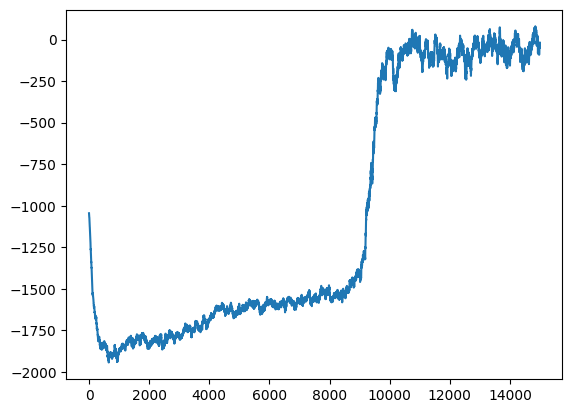

In [49]:
# Smooth plot
weight=0.99
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.plot(smoothed)

You need to complete the following method to visualize your training results.

In [51]:
def visualize(q_table, env):
    v_table = {}  # To store V-values for each state
    policy = {}  # To store the optimal policy for each state

    for state, q_values in q_table.items():
        v_table[state] = np.max(list(q_values.values()))  # V-value is the maximum Q-value for a state
        policy[state] = np.argmax([q_values[action] for action in CliffBoxGridWorld.action_space]) + 1  # Optimal policy

    # Create tables to store V-values and policy
    v_table_table = [["V-Values"]]
    policy_table = [["Policy"]]

    for agent_x in range(env.world_height):
        v_row = []
        policy_row = []
        for agent_y in range(env.world_width):
            state = (agent_x, agent_y, env.init_box_pos[0], env.init_box_pos[1])
            v_row.append(f"{v_table[state]:.2f}")
            policy_row.append(policy[state])
        v_table_table.append(v_row)
        policy_table.append(policy_row)

    # Print V-values table
    print("V-Values Table:")
    for row in v_table_table:
        print(" | ".join(row))

    # Print Policy table
    print("Policy Table:")
    for row in policy_table:
        print(" | ".join(map(str, row)))

    done = False
    rewards = []

    while not done:
        for actions in policy_table[1:]:
            for action in actions:
                state, reward, done, info = env.step(action)
                rewards.append(reward)
                print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
                env.print_world()

# Call the visualize function with your RL agent's Q-table and the environment
env = CliffBoxGridWorld(render = True)
env.reset()
env.print_world()
visualize(agent.q_table, env)

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
V-Values Table:
V-Values
-274.39 | -272.38 | -267.28 | -260.57 | -254.01 | -248.58 | 0.00 | 0.00 | -180.17 | -179.34 | -175.93 | -172.31 | -165.22 | -160.33
-276.99 | -274.86 | -270.72 | -261.56 | -251.09 | -246.46 | 0.00 | 0.00 | -182.96 | -182.97 | -180.34 | -173.54 | -163.72 | -156.25
-281.59 | -280.75 | -278.94 | 0.00 | -242.58 | -240.53 | 0.00 | 0.00 | -190.27 | -188.74 | -185.49 | -178.33 | 0.00 | -146.93
-116.80 | -284.47 | -284.58 | 0.00 | -235.81 | -234.13 | 0.00 | -205.65 | -198.51 | -194.73 | -192.83 | 0.00 | 0.00 | -142.89
363.40 | 0.00 | -113